A model with real unknowns has been initialized
Disk with radius 1 has been meshed
Domain has been set
Domain is set and contains 1 mesh(es):
=== on mesh 0 of dim 2
* Subdomains are: {'Omega': 1}
* Boundaries are: {'Gamma': 10}
domain: Disk has been set
state: h has been added
port: h has been added 
costate: e_h has been added to state: h
state: h has new costate: e_h
FEM_PK(2,1) has been set for port h
rho has been added to port: h
rho has been set to 1025.0 in port: h
rho has been initialized with the FEM of port: h
port: Boundary control 0 has been added on region 10
state: p has been added
port: p has been added 
costate: e_p has been added to state: p
state: p has new costate: e_p
FEM_PK(2,2) has been set for port p
g has been added to port: h
g has been set to 9.81 in port: h
g has been initialized with the FEM of port: h
FEM_PK(2,1) has been set for port Boundary control 0
Linear form  'h * Test_h' has been added as: flow relation on region: 1 of mesh: 0
Non-linear form  'h * p

message from gf_mesh_get follow:
gfMesh object in dimension 2 with 90 points and 149 elements

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 90 points, 149 elements and 89 degrees of freedom

Parameter rho has been evaluated with the fem of port ' h ', with expression: 1025.0
message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 90 points, 149 elements and 652 degrees of freedom

Parameter g has been evaluated with the fem of port ' h ', with expression: 9.81
message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 90 points, 149 elements and 89 degrees of freedom

i=       0 t=       0 * (0s)   dt=  0.0001        
i=       8 t=0.0139554 * (0s)   dt=0.00701718         
i=      10 t=0.0285068 * (0s)   dt=0.00717934        
i=      12 t=0.0427398 * (0s)   dt=0.0074792         
i=      14 t=0.0570482 * (0s)   dt=0.00625773        
i=      16 t=0.069829 * (1s)   dt=0.00645837         
i=      18 t=0.0821403 * (1s)   dt=0.0058

Elapsed time: 6.63s
Steps: 110 (4 rejected, 0 Nonlinear solver failures)
Nonlinear iterations: 115, Linear iterations: 115
Start computing the Hamiltonian
Hamiltonian has been computed in 0.027895204722881317 s
Start computing the powers (substituted ports are not automated)
Power cannot be computed for dynamic or substituted port h
Start computing the power flowing through Boundary control 0
Power in Boundary control 0 has been computed in 0.004478968679904938 s
Power cannot be computed for dynamic or substituted port p
Powers have been computed in 0.0056368689984083176 s


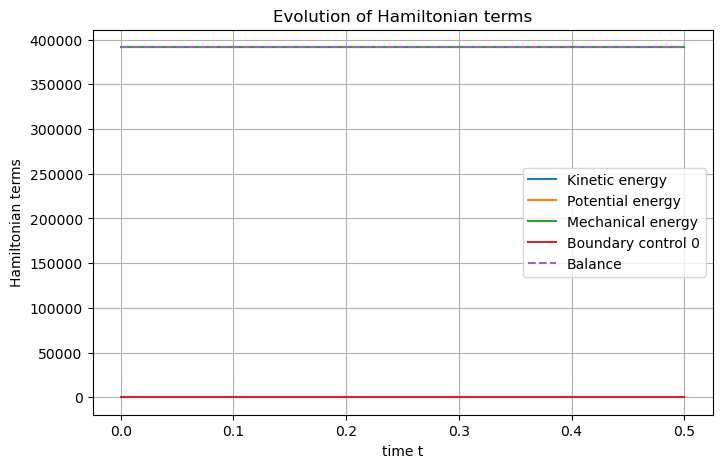

In [1]:
import scrimp as S
from itertools import zip_longest

# Init the distributed port-Hamiltonian system
swe = S.DPHS("real")

## Macros
swe.gf_model.add_macro('div(v)', 'Trace(Grad(v))')
swe.gf_model.add_macro('Rot', '[[0,1],[-1,0]]')
swe.gf_model.add_macro('Tangent', '(Rot*Normal)')
swe.gf_model.add_macro('Curl2D(v)', 'div(Rot*v)')
swe.gf_model.add_macro('Gyro(v)', 'Curl2D(v)*Rot')

# Set the domain (using the built-in geometry `Disk`)
swe.set_domain(S.Domain("Disk", {"R": 1, "h": 0.25}))

## Define the variables and their discretizations
states = [
    S.State("h", "Fluid height", "scalar-field"),
    S.State("p", "Linear momentum", "vector-field"),
]
costates = [
    S.CoState("e_h", "Pressure", states[0]),
    S.CoState("e_p", "Velocity", states[1]),
]
ports = []
rho = 1025.0
g = 9.81
params = [
    S.Parameter("rho", "Mass density", "scalar-field", f"{rho}", "h"),
    S.Parameter("g", "Gravity", "scalar-field", f"{g}", "h"),
]

control_ports = [
    S.Control_Port(
        "Boundary control 0",
        "U_0",
        "Normal velocity",
        "Y_0",
        "Fluid height",
        "scalar-field",
        region=10,
        position="effort",
    ),
]

FEMs = [
    # name of the variable: (is the same of states, ports and controls ports), order, FEM
    S.FEM(states[0].get_name(), 1, FEM="CG"),
    S.FEM(states[1].get_name(), 2, FEM="CG"),
    S.FEM(control_ports[0].get_name(), 1, "CG"),
]

for state, costate, param, fem, port, control_port in zip_longest(
    states, costates, params, FEMs, ports, control_ports
):
    if state is not None:
        # Add a state
        swe.add_state(state)
    if costate is not None:
        # Add its co-state
        swe.add_costate(costate)
    if fem is not None:
        # Add a Finite Element Method to the `port`
        swe.add_FEM(fem)
    if param is not None:
        # Add a (possibly space-varying) parameter to the `port`
        swe.add_parameter(param)
    if port is not None:
        # Add a resistive `port`
        swe.add_port(port)
    if control_port is not None:
        # Add a control `port` on the bottom part of the boundary (Neumann, thus position='effort' - default)
        swe.add_control_port(control_port)

## Set Hamiltonian
swe.hamiltonian.set_name("Mechanical energy")

terms = [
    S.Term("Kinetic energy", "0.5*h*p.p/rho", [1]),
    S.Term("Potential energy", "0.5*rho*g*h*h", [1]),
]

for term in terms:
    # Set the Hamiltonian (can be done later, even after solve)
    swe.hamiltonian.add_term(term)

## Define the Dirac structure via getfem `brick` = non-zero block matrix
bricks = [
    # Define the mass matrices of the left-hand side of the "Dirac structure" (position="flow")
    S.Brick("M_h", "h * Test_h", [1], dt=True, position="flow"),
    S.Brick("M_p", "h * p . Test_p", [1], dt=True, linear=False, position="flow"),
    S.Brick("M_Y_0", "Y_0 * Test_Y_0", [10], position="flow"),

    # Define the first line of the right-hand side of the "Dirac structure" (position="effort")
    S.Brick("-D^T", "h * e_p . Grad(Test_h)", [1], linear=False, position="effort"),
    # with the boundary control
    S.Brick("B_0", "- U_0 * Test_h", [10], position="effort"),
    # Define the second line of the right-hand side of the "Dirac structure" (position="effort")
    S.Brick("D", "- Grad(e_h) . Test_p * h", [1], linear=False, position="effort"),
    # with the gyroscopic term (beware that "Curl" is not available in the GWFL of getfem)
    S.Brick("G", "h * (Gyro(p) * e_p) . Test_p", [1], linear=False, explicit=True, position="effort"),
    # Define the third line of the right-hand side of the "Dirac structure" (position="effort")
    S.Brick("C_0", "e_h * Test_Y_0", [10], position="effort"),
    # Define the constitutive relations (position="constitutive", the default value)
    # For e_h: first the mass matrix WITH A MINUS because we want an implicit formulation 0 = - M e_h + F(h)
    S.Brick("-M_e_h", "- e_h * Test_e_h", [1]),
    # second the linear part as a linear brick
    S.Brick("CR_h_lin", "rho * g * h * Test_e_h", [1]),
    # third the non-linear part as a non-linear brick (linear=False)
    S.Brick("CR_h_nl", "0.5 * (p . p) / rho * Test_e_h", [1], linear=False, explicit=True),
    # For e_p: first the mass matrix WITH A MINUS because we want an implicit formulation 0 = - M e_p + F(p)
    S.Brick("-M_e_p", "- e_p . Test_e_p", [1]),
    # second the non-linear brick (linear=False)
    S.Brick("CR_p", "p / rho . Test_e_p", [1]),
]

for brick in bricks:
    swe.add_brick(brick)

## Initialize the problem
swe.set_control("Boundary control 0", "0.")

# Set the initial data
swe.set_initial_value(
    "h", "5."
)
swe.set_initial_value(
    "p",
    f"[ -0.2*{rho}*np.sin(np.pi*np.sqrt(x*x+y*y))*np.sin(np.arctan2(y,x)), 0.2*{rho}*np.sin(np.pi*np.sqrt(x*x+y*y))*np.cos(np.arctan2(y,x))]",
)

## Solve in time

# Define the time scheme (default ts_type='cn', t_f=1, dt=0.01, etc.)
swe.set_time_scheme(
    ts_type="bdf",
    ts_bdf_order=4,
    ksp_type="preonly",
    pc_type="lu",
    pc_factor_mat_solver_type="mumps",
    t_0=0.0,
    t_f=0.5,
    dt=0.0001,
    dt_save=0.01,
    ts_adapt_dt_min=0.00001,
    init_step=True,
)

# Solve the system in time
swe.solve()

# Plot the Hamiltonian
swe.plot_Hamiltonian(with_powers=True)